<a href="https://colab.research.google.com/github/aagarwal17/datasci-207-arun/blob/main/09_Embeddings_for_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 9

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [40]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow.keras.datasets import imdb

---
### Step 1: Data ingestion

In this lab, you'll train a <span style="color:chocolate">sentiment</span> classifier for movie reviews.

* The input is the text of a movie review;
* The output is the probability the input is a positive review.
* The target labels are binary, 0 for negative and 1 for positive.

The data includes 50,000 movie reviews on IMDB. The data comes pre-segmented into train and test splits. The [data loading function](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) below also splits each input text into tokens (words), and maps the words to integer values. Each input is a sequence of integers corresponding to the words.

In [3]:
# read data
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)


---
### Step 2: Data preprocessing

Let's have a look at the first training example:

In [4]:
print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
First t

As you can see, the first training example is a positive review. However, that sequence of integer IDs is hard to read.

The data loader provides a dictionary mapping words to IDs. Let's create a reverse index.


In [5]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Largest ID: 88587


Note that our index (and reverse index) have <span style="color:chocolate">88,587</span> tokens. That's quite <span style="color:chocolate">a large vocabulary</span>!

Next, let's write a decoding function for our data.

In [6]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

---
### Step 3: Exploratory Data Analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Text lengths (10 points)

Using the training reviews data, answer the following questions:

1. What are the minimum, maximum, and mean lengths of positive and negative reviews?
2. Create a histogram to visualize the distribution of positive and negative review lengths. Make sure to provide a descriptive title and axis labels.

Positive Reviews:
Min Length: 13
Max Length: 2494
Mean Length: 241.56296
Negative Reviews:
Min Length: 11
Max Length: 1571
Mean Length: 235.86432


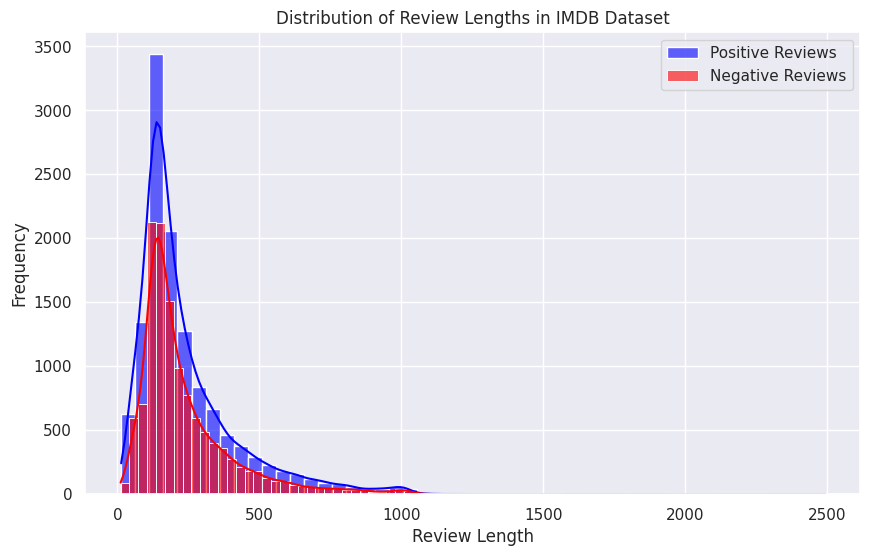

In [7]:
# YOUR CODE HERE
review_lengths = [len(review) for review in X_train]
# Separate lengths based on labels
pos_lengths = [len(X_train[i]) for i in range(len(X_train)) if Y_train[i] == 1]
neg_lengths = [len(X_train[i]) for i in range(len(X_train)) if Y_train[i] == 0]
# 1:
min_pos, max_pos, mean_pos = np.min(pos_lengths), np.max(pos_lengths), np.mean(pos_lengths)
min_neg, max_neg, mean_neg = np.min(neg_lengths), np.max(neg_lengths), np.mean(neg_lengths)
print("Positive Reviews:")
print("Min Length:", min_pos)
print("Max Length:", max_pos)
print("Mean Length:", mean_pos)
print("Negative Reviews:")
print("Min Length:", min_neg)
print("Max Length:", max_neg)
print("Mean Length:", mean_neg)

plt.figure(figsize=(10, 6))
sns.histplot(pos_lengths, bins=50, color='blue', label='Positive Reviews', kde=True, alpha=0.6)
sns.histplot(neg_lengths, bins=50, color='red', label='Negative Reviews', kde=True, alpha=0.6)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths in IMDB Dataset")
plt.legend()
plt.show()

### <span style="color:chocolate">Exercise 2:</span> Token counts (10 points)

Using the training data, create a table listing the counts of positive and negative examples that contain each token provided below.

In [17]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']
token_ids = [index[token] for token in tokens]
token_counts = {token: {'Positive': 0, 'Negative': 0} for token in tokens}

# Count token occurrences in positive and negative reviews
for i in range(len(X_train)):
    words = X_train[i]
    for token in token_ids:
        if token in words:
            if Y_train[i] == 1:
                token_counts[reverse_index[token]]['Positive'] += 1
            else:
                token_counts[reverse_index[token]]['Negative'] += 1

# Convert to DataFrame:
df = pd.DataFrame.from_dict(token_counts, orient='index')
df.index.name = 'Token'
df.columns = ['Positive Count', 'Negative Count']
df

,Positive Count,Negative Count
Token,,
good,4767,4849
bad,1491,4396
amazing,868,240
boring,301,1205
laugh,525,685
cry,231,114


---
### Step 4: Data preprocessing (cont'd)

As is clear from the review length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, you will add special padding tokens at the end of each review until they are all the same length. You will also truncate all training inputs to a specified length.

### <span style="color:chocolate">Exercise 3:</span> Reduced length and padding (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">truncate_pad_data()</span> function below by following these instructions:

1. Restrict the maximum number of tokens by truncating all reviews to a length of 300;
2. Append special padding tokens (value = 0) to the end of each review until all reviews are of the same length.

In [18]:
def truncate_pad_data(sequences, max_length):
    # Keras has a convenient utility for padding a sequence:
    # tf.keras.preprocessing.sequence.pad_sequences()
    # Also make sure you get a numpy array rather than an array of lists.
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post', value=0)
    return np.array(padded_data)

# 1+ 2: Truncate and pad the training data
X_train_padded = truncate_pad_data(X_train, max_length=300)

# Check the padded output
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

Next, you want to be able to limit the vocabulary size. Since the <span style="color:chocolate">truncate_pad_data()</span> function produces fixed-length sequences in a numpy matrix, one can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

### <span style="color:chocolate">Exercise 4:</span> Reduced vocabulary (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">limit_vocab()</span> function below by following these instructions:

1. Keep just token ids less than 1000, replacing all others with OOV.

In [19]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  # YOUR CODE HERE
  reduced_sequences = np.where(sequences >= max_token_id, oov_id, sequences)
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17 515  17  12  16 626  18   2   5  62 386
  12   8 316   8 106   5   4   2   2  16 480  66   2  33   4 130  12  16
  38 619   5  25 124  51  36 135  48  25   2  33   6  22  12 215  28  77
  52   5  14 407  16  82   2   8   4 107 117   2  15 256   4   2   7   2
   5 723  36  71  43 530 476  26 400 317  46   7   4   2   2  13 104  88
   4 381  15 297  98  32   2  56  26 141   6 194   2  18   4 226  22  21
 134 476  26 480   5 144  30   2  18  51  36  28 224  92  25 104   4 226
  65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### <span style="color:chocolate">Exercise 5:</span> One-hot encoding (0 points)

The current feature representations are **sparse**. That is, one only keeps track of the token ids that are present in the input. A **one-hot** encoding replaces a value like 22 (corresponding to 'film') with an array with a single 1 at position 22 and zeros everywhere else. This will be very memory-inefficient, but we'll do it anyway for clarity.

To avoid any memory limitations, let's dramatically reduce both the number of token positions (review length) and the number of token ids (vocabulary).

The code below clips each review after 20 tokens and keeps only the first 1000 tokens.

In [20]:
# Keras has a util to create one-hot encodings.
X_train_padded = truncate_pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_one_hot shape: (25000, 20, 1000)


Note the shape of the one-hot encoded features. For each of the 25000 training examples, you have a 20 x 1000 matrix. That is, for each of 20 token positions, you have a vector of 1000 elements containing a single 1 and 999 zeros.

You can think of these 1000-dimensional one-hot arrays as **embeddings**. Each token in the input has a 1000-dimensional representation. But because of the one-hot setup, the distance between each pair of tokens is the same ([1,0,0,...], [0,1,0,...], etc.). By contrast, learned embeddings result in meaningful distances between pairs of tokens. You'll get to that soon.

---
### Step 5: Modeling

### <span style="color:chocolate">Baseline model:</span> Logistic regression with one-hot encodings

You will start with something familiar -- logistic regression. Since your feature representation is in 2 dimensions (20 x 1000), you need to flatten it to pass it to Keras (remember you did this with the pixel data too). Try two strategies for flattening.

1. Flatten by *concatenating* (as you did with pixels), turning (20 x 1000) data into (20000,) data. The result is a separate feature for each token at each position;
2. Flatten by *averaging* over token positions, turning (20 x 1000) data into (1000,) data. The result is an array with average token counts, ignoring position.

In [21]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for binary classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

Now let's try fitting the model to your training data and check performance metrics on the validation data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [22]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5591 - loss: 0.6877 - val_accuracy: 0.6096 - val_loss: 0.6745
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6952 - loss: 0.6515 - val_accuracy: 0.6200 - val_loss: 0.6623
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7281 - loss: 0.6227 - val_accuracy: 0.6248 - val_loss: 0.6536
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7484 - loss: 0.5986 - val_accuracy: 0.6244 - val_loss: 0.6471
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7630 - loss: 0.5778 - val_accuracy: 0.6308 - val_loss: 0.6421


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          20,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,005 (234.40 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,004 (156.27 KB)

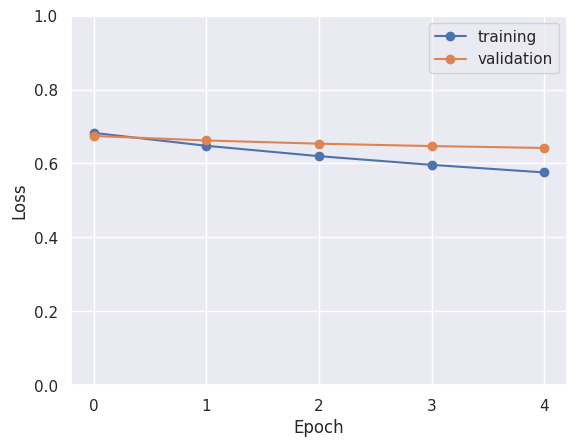

In [23]:
model1 = build_onehot_model()

# Fit the model.
history1 = model1.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model1.summary()
# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history1 = pd.DataFrame(history1.history)
plot_history(history1)

### <span style="color:chocolate">Exercise 6:</span>  Comparing logistic regression models (20 points)

Train the one-hot model using both the concatenating and the averaging strategies and compare the results. Let's call these *LR-C* (Logistic Regression Concatenating) and *LR-A* (Logistic Regression Averaging). Then answer the following questions:

1. What are the final training and validation accuracies for LR-C and LR-A?
2. How many parameters are there in each model?
3. Would you say that either model is overfitting? Why or why not?
4. Briefly describe how LR-C differs from LR-A. How do you explain the relationship between their respective validation accuracy results?

In [24]:
# Train the model with concatenation (LR-C):
LR_C = build_onehot_model(average_over_positions=False)
history_concat = LR_C.fit(X_train_one_hot, Y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

# Train the model with averaging (LR-A):
LR_A = build_onehot_model(average_over_positions=True)
history_avg = LR_A.fit(X_train_one_hot, Y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5516 - loss: 0.6881 - val_accuracy: 0.6124 - val_loss: 0.6745
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6949 - loss: 0.6517 - val_accuracy: 0.6188 - val_loss: 0.6623
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7282 - loss: 0.6227 - val_accuracy: 0.6220 - val_loss: 0.6537
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7496 - loss: 0.5986 - val_accuracy: 0.6280 - val_loss: 0.6472
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7659 - loss: 0.5779 - val_accuracy: 0.6288 - val_loss: 0.6421
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5394 - loss: 0.6926 - val_accuracy: 0.5904 - val_loss: 0.6900
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6160 - loss: 0.6888 - val_accuracy: 0.6068 - val_loss: 0.6867
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6288 - loss: 0.6854 - val_accuracy: 0.6108 -

In [25]:
# Evaluate models on validation data
val_acc_concat = LR_C.evaluate(X_train_one_hot, Y_train, verbose=0)[1]
val_acc_avg = LR_A.evaluate(X_train_one_hot, Y_train, verbose=0)[1]
print(f"LR-C (Concatenation) - Final Training Accuracy: {history_concat.history['accuracy'][-1]:.4f}, Final Validation Accuracy: {val_acc_concat:.4f}")
print(f"LR-A (Averaging) - Final Training Accuracy: {history_avg.history['accuracy'][-1]:.4f}, Final Validation Accuracy: {val_acc_avg:.4f}")

LR-C (Concatenation) - Final Training Accuracy: 0.7599, Final Validation Accuracy: 0.7661
LR-A (Averaging) - Final Training Accuracy: 0.6335, Final Validation Accuracy: 0.6346


In [26]:
LR_C.summary()
LR_A.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          20,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,005 (234.40 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,004 (156.27 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ global_average_pooling1d             │ (None, 1000)                │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,005 (11.74 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,004 (7.83 KB)

*Written answer:*

1. LR-C (Concatenation) - Final Training Accuracy: 0.7599, Final Validation Accuracy: 0.7661. LR-A (Averaging) - Final Training Accuracy: 0.6335, Final Validation Accuracy: 0.6346

2. There are 60005 parameters in the LR-C (Concatenation) model, and 3005 parameters in the LR-A (Averaging) model.

3. Neither model is overfitting because the training and validation accuracies are relatively close in both cases. However, LR-C appears to be more effective at learning the patterns in the data, as it gets higher training and validation accuracies. LR-A, on the other hand, has a worse performance, but since the accuracies are close, it is not overfitting either. The difference in performance is more likely due to LR-C's larger model complexity, allowing it to be fitting the data better.

4. LR-C (Concatenation) flattens the token sequence by concatenating all token positions, creating a long vector that is preserving both the token values and their positions in the sequence. This allows the model to capture more detailed relationships, resulting in the higher accuracy. In contrast, LR-A (Averaging) averages the token values across all positions, simplifying the representation by treating the sequence as a bag of tokens without positional context. The higher validation accuracy of LR-C (0.7661) suggests that the model benefits from maintaining sequence structure, while LR-A (0.6346) struggles because it loses information about token order. LR-C’s ability to capture position-specific relationships leads to better performance on more complex data.

### <span style="color:chocolate">Improvement over baseline:</span> Logistic regression with embeddings

Next, you will train a model that replaces one-hot representations of each token with learned embeddings.

The code below uses a Keras Embedding layer, which expects to receive a sparse (rather than one-hot) representation. That is, it expects a (padded) sequence of token ids; for each id, it looks up the corresponding embedding vector.

In [27]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

You will train this model, this time using the averaging strategy instead of the concatenating strategy for handling the token sequence. You'll look up the embedding vectors for each token and average them to produce a single vector. Then, you'll use this averaged vector to train a logistic regression model to predict the binary label.

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5518 - loss: 0.6909 - val_accuracy: 0.5988 - val_loss: 0.6827
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6224 - loss: 0.6782 - val_accuracy: 0.6156 - val_loss: 0.6675
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6414 - loss: 0.6617 - val_accuracy: 0.6332 - val_loss: 0.6519
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6585 - loss: 0.6448 - val_accuracy: 0.6488 - val_loss: 0.6378
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6709 - loss: 0.6295 - val_accuracy: 0.6576 - val_loss: 0.6259


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 2)               │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 2)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

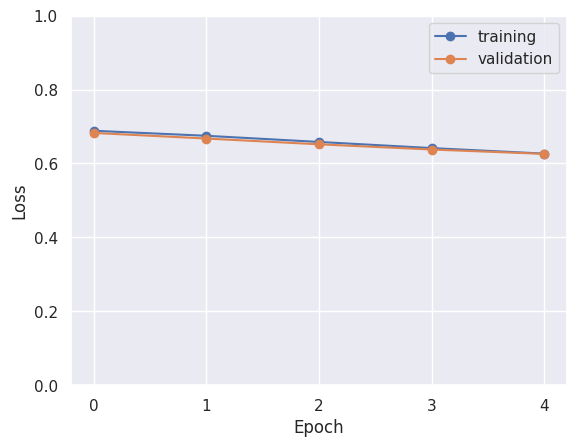

In [28]:
model2 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history2 = model2.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model2.summary()

history2 = pd.DataFrame(history2.history)
plot_history(history2)

### <span style="color:chocolate">Exercise 7:</span> Embedding size tuning (20 points)

Experiment with embedding sizes {2, 4, 8, 16, 32, 64}, while keeping other settings fixed and using the averaging strategy instead of the concatenating strategy. Then:

1. Construct a table showing the training and validation accuracies for each model after 5 training epochs;
2. Calculate the number of parameters in each model;
3. Analyze whether learned embeddings improve performance compared to one-hot encoding, and explain why this might be the case.

In [30]:
import tensorflow as tf

# Now, run the experiment again with the embedding sizes
embedding_sizes = [2, 4, 8, 16, 32, 64]
train_accuracies = []
val_accuracies = []
parameters_list = []

# Experimenting with different embedding sizes:
for embedding_dim in embedding_sizes:
    model = build_embeddings_model(average_over_positions=True, vocab_size=1000, sequence_length=20, embedding_dim=embedding_dim)
    history = model.fit(x = X_train_reduced, y = Y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=0)
    train_accuracies.append(history.history['accuracy'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])
    parameters_list.append(model.count_params())

embeddings_results_df = pd.DataFrame({
    'Embedding Size': embedding_sizes,
    'Training Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Parameters': parameters_list
})
embeddings_results_df

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


,Embedding Size,Training Accuracy,Validation Accuracy,Parameters
0,2,0.664800,0.6536,2003
1,4,0.682133,0.6644,4005
2,8,0.691822,0.6732,8009
3,16,0.700489,0.6864,16017
4,32,0.703378,0.6880,32033
5,64,0.702489,0.6912,64065


*Written answer:*

1. The results in the dataframe above show a consistent improvement in both training and validation accuracy as the embedding size increases from 2 to 32, with the best performance seen at an embedding size of 32. This suggests that larger embedding sizes help the model capture more complex relationships and nuances in the data, leading to better predictive performance. However, after 32 dimensions, the training accuracy slightly plateaued, and the validation accuracy slightly increased. Still, embedding sizes of 32 and 64 show nearly identical results. This indicates that beyond a certain point, increasing the embedding size does not significantly improve the model's performance, possibly due to overfitting or diminishing returns after a large enough embedding size to generalize effectively.

2. The number of parameters in the model grows exponentially with the embedding size, starting from 2003 parameters for an embedding size of 2, to 64065 parameters for an embedding size of 64. Specifically, removing the one bias term, as the embedding size doubles, the parameter count doubles as well. This increase is because of the additional weights in the embedding layer for each token in the vocabulary and each dimension of the embedding. While the number of parameters increases significantly, the validation accuracy improves only slightly beyond an embedding size of 32, indicating that after a certain point, increasing the embedding size does not result in substantial performance gains.

3. Accuracy wise, the best validation accuracy we see for one-hot encoding with averaging is 0.6346, and the best for embeddings is 0.6912. Learned embeddings improve performance compared to one-hot encoding because they represent tokens in a dense, continuous vector space, where similar words are positioned closer together. One-hot encoding creates sparse vectors with no inherent relationships between tokens, treating all words as equally distant. Embeddings allow the model to capture semantic relationships, like synonyms or context, which enhances its ability to make accurate predictions. Additionally, embeddings reduce the model’s parameter count compared to one-hot encoding, making the model more efficient, especially for large vocabularies. As seen in the results, models with embeddings consistently outperform those using one-hot encoding, achieving better validation accuracy.


---

### Inspecting Learned Embeddings
You will now retrieve the learned embedding parameters from the trained model2 and plot the token embeddings.

The model layers in a Keras Sequential model are stored as a list and the embeddings are the first layer. You can use the <span style="color:chocolate">get_weights()</span> function to get a numpy array with the parameters.

In [31]:
# Display the model layers.
display(model2.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings2 = model2.layers[0].get_weights()[0]
display(embeddings2.shape)

[<Embedding name=embedding, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d, built=True>,
 <Dense name=dense, built=True>]

(1000, 2)

Now you'll use a fancy plotting tool called *plotly* to show the embeddings with hovertext so you can move your mouse over the points to see the corresponding tokens.

In [41]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]

  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.
plot_2d_embeddings(embeddings2, id_start=500, count=500)

In [35]:
reverse_index[7]

'of'

In [42]:
def plot_2d_embeddings_highlight(embeddings, id_start=1, count=100, highlight_ids=[7, 8, 9]):
    x1 = embeddings[id_start:id_start+count, 0]
    x2 = embeddings[id_start:id_start+count, 1]

    tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

    data = plotly.Scatter(x=x1, y=x2, text=tokens,
                          mode='markers', textposition='bottom left',
                          hoverinfo='text', marker=dict(color='blue', size=6))

    # Highlight specific tokens (7, 8, and 9):
    highlight_x1 = embeddings[highlight_ids, 0]
    highlight_x2 = embeddings[highlight_ids, 1]
    highlight_tokens = [reverse_index[i] for i in highlight_ids]
    highlight_data = plotly.Scatter(x=highlight_x1, y=highlight_x2, text=highlight_tokens,
                                    mode='markers+text', textposition='bottom left',
                                    hoverinfo='text', marker=dict(color='red', size=10))
    fig = plotly.Figure(data=[data, highlight_data],
                        layout=plotly.Layout(title="Word Embeddings with Highlighted Tokens",
                                             hovermode='closest'))
    fig.show()

plot_2d_embeddings_highlight(embeddings2, id_start=500, count=500)

### <span style="color:chocolate">Exercise 8:</span> Interpreting embeddings (20 points)

Notice that the 2-D embeddings fall in a narrow diagonal band. Answer the following questions:

1. Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?
2. Give 2 examples of words that seem to have surprising embedding values and try to explain their positions. For example, what's going on with the tokens '7', '8', and '9'? What are two other surprising results?
3. The embedding for 'crazy' is very close to (0,0). Explain what this means in terms of the model's output.
4. Can you explain what you think the 2 learned embedding dimensions mean, if anything?

YOUR ANSWER HERE

1. Yes, the learned embeddings have effectively separated positive and negative words. Positive words are positioned along the diagonal starting from the bottom-left corner, becoming less positive or more neutral as they move towards the center. Conversely, negative words are placed along the diagonal starting from the top-right corner, gradually transitioning from more negative to less negative or more neutral as they approach the center. This diagonal separation reflects how the embedding space captures the polarity of the words, with the central area representing neutral words that don't strongly lean toward either sentiment. The most negative word is then horrible, which is sensible for a movie review. This embedding attempts to position words with similar meanings or sentiments closer together in the embedding space. By placing positive words on one side and negative words on the other, the model organizes the sentiment-related features in a meaningful way. The gradual shift from extreme sentiment (positive or negative) to more neutral words as you move toward the center of the diagonal reflects the natural variation in sentiment, with neutral words not strongly favoring either polarity. This aligns with how sentiment is often distributed across different words.

2. Modern and child are very close to the positive side of the embedding plot, however the words are objectively neutral. However, in context of movies/in relation to other words, they are most likely to be mentioned when providing a positive review of the movie (describing details of the movie like a child doing a well job and it being a modern take on a prior film). On the opposing side, starts is labeled more negatively but in reality is pretty neutral. It is most likely because, in context of a movie review, the writer is going into detail about the plot of the movie and how it starts a certain way and changes track, making it a bad movie. Also on the negative side is review, suggesting that when a writer writes the word review in their review, they are more likely to be writing a negative review. Tokens 7, 8, and 9 are the words "is", "of", and "to", which are all small neutral connecting words that should in reality be closer to the middle of the graph, however, "is" is more positive, and "to" is more negative ("of" neutral), suggesting when saying something "is" something, it is used in more positive reviews, and when using the word "to", it is used in more negative reviews, which does not seem sensible.

3. "crazy" is very close to 0 most likely because it can be used in both positive and negative contexts a fairly equal amount of times. You can say a movie is crazy good (or a crazy idea), or crazy bad (or a crazy person). The model has learned to treat it as a neutral or context-dependent word. The model places it in a central position in the embedding space, indicating that it doesn't have a clear sentiment polarity on its own. The model likely relies on surrounding words or context to determine sentiment, rather than treating "crazy" as inherently positive or negative.

4. The two learned embedding dimensions are probably capturing different aspects of the relationships between the tokens, like semantic meaning and sentiment. The first dimension may represent a general positivity or negativity axis, with positive words clustered towards one end and negative words towards the other, while the second dimension could capture another relationships, such as intensity or context. For example, words like "amazing" or "love" may be positioned on the positive end of the first axis and spread out on the other dimension based on the strength of the sentiment, while words like "sad" or "horrible" would cluster at the opposite end, again spread out as horrible might have a stronger sentiment. Words that don't clearly fit into a positive or negative sentiment (like "crazy") may fall closer to the center, reflecting a neutral or ambiguous sentiment. Since the dimensions are learned based on the data and context, the exact meaning is hard to say.


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

More data and bigger models

Remember how you limited your input sequences to 20 tokens and 1000 vocabulary entries? Let's see how well you can do using more data and bigger models (more parameters).

Using pieces of code from above, set up and train a model to achieve at least 80% accuracy on both training and validation data. Ensure the following elements are included:

1. Truncate and pad input to the desired length;
2. Limit the vocabulary to the desired size;
3. Set up a model using embeddings;
4. Use the averaging strategy rather than the concatenating strategy;
5. Add additional layer(s) after the GlobalAveragePooling1D layer and before the output layer;
6. Evaluate the model's performance on the test data and comment on its generalization performance. Hint: remember to apply the same preprocessing to the test data. Use the <span style="color:chocolate">model.evaluate()</span> function for the final evaluation.

In [ ]:
# YOUR CODE HERE